In [3]:
from typing import Tuple, Optional
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom

from jaxtyping import Array, PRNGKeyArray
import numpy as np
import optax

In [4]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [5]:
# def get_data_spirals(dataset_size, *, key):
#     t = jnp.linspace(0, 2 * math.pi, 16)
#     offset = jrandom.uniform(key, (dataset_size, 1), minval=0, maxval=2 * math.pi)
#     x1 = jnp.sin(t + offset) / (1 + t)
#     x2 = jnp.cos(t + offset) / (1 + t)
#     y = jnp.ones((dataset_size, 1))

#     half_dataset_size = dataset_size // 2
#     x1 = x1.at[:half_dataset_size].multiply(-1)
#     y = y.at[:half_dataset_size].set(0)
#     x = jnp.stack([x1, x2], axis=-1)
#     #x = x + jrandom.normal(key, x.shape) * 0.3
#     return x, y

# # Test data generation and visualize the data samples
# dataset_size = 1024
# key = jax.random.key(10)
# x, y = get_data_spirals(dataset_size, key=key)
# class0 = x[y[:, 0] == 0]
# class1 = x[y[:, 0] == 1]
# for spiral in class0[0:5]:
#     plt.plot(spiral[:, 0], spiral[:, 1], color="blue")
# for spiral in class1[105:110]:
#     plt.plot(spiral[:, 0], spiral[:, 1], color="red")
# plt.show()

In [6]:
# key = jax.random.key(28)
# m = jrandom.randint(key, (dataset_size,), minval=200, maxval=1000)
# key, subkey = jrandom.split(key)
# n = jrandom.randint(key, (dataset_size,), minval=200, maxval=1000)
# key, subkey = jrandom.split(key)
# rank = jrandom.randint(key, (dataset_size,), minval=1, maxval=100)

# # percent of cases where the rank is less than 1/10 of the minimum of m and n:
# print(jnp.mean(rank < jnp.minimum(m, n) / 10))

In [7]:
# Create data generator where X is a large, dense, low rank (m x n) matrix of random size and rank
# with some percentage of the entries masked (set to zero)
# and Y is whether the rank of the unmasked matrix is smaller than the threshold of min(m, n) / threshold
def get_data_densematrix(dataset_size: int, m: int, n: int, *, 
                         key: jax._src.prng.PRNGKeyArray, measurement_type: str = "mask",
                         include_X: bool = False, mask_prob: float = 0.33, 
                         rank_threshold: float = 0.1) -> Tuple[jnp.ndarray, jnp.ndarray, 
                                                               jnp.ndarray, jnp.ndarray]:
    # Generate matrix ranks
    rank = jrandom.randint(key, (dataset_size,), 
                           minval=1, maxval=jnp.minimum(jnp.minimum(m, n)/2, 100))
    key, subkey = jrandom.split(key)
    n_seen = jnp.round((1 - mask_prob) * m * n).astype(jnp.int32)
    rank = jnp.minimum(rank, n_seen // 2)
    
    # Generate low-rank matrices by multiplying m x r and r x n matrices
    key, subkey = jrandom.split(key)
    A = jrandom.normal(subkey, (dataset_size, m, rank.max()))
    A = [A[i, :, :rank[i]] for i in range(dataset_size)]
    key, subkey = jrandom.split(key)
    B = jrandom.normal(subkey, (dataset_size, rank.max(), n))
    B = [B[i, :rank[i], :] for i in range(dataset_size)]
    key, subkey = jrandom.split(key)
    X = jnp.stack([jnp.dot(A[i], B[i]) for i in range(dataset_size)])
    #X = jnp.einsum("ijk,ikl->ijl", A, B)
    # Generate labels with shape (dataset_size, 1)
    Y = (rank < jnp.minimum(m, n) * rank_threshold).astype(jnp.int32)
    Y = Y[:, None]
    
    if measurement_type == "mask":
        # Generate measurements of each X by masking some of the entries; dataset_size x m x n
        masks = jrandom.bernoulli(subkey, 1-mask_prob, (dataset_size, m, n))
        key, subkey = jrandom.split(key)
        Xhat = X * masks
    
    elif measurement_type == "trace":
        # Generate measurements of each X by taking Trace(X * O_i) for (2*maxrank) random matrices O_i
        O = jrandom.normal(subkey, (dataset_size, 250, m, 50))
        # Function to compute the trace of the product of two matrices
        def trace_product(X, O):
            trace = jnp.trace(jnp.matmul(X, O), axis1=-2, axis2=-1)
            return trace
        vectorized_trace_product = jax.vmap(jax.vmap(trace_product, in_axes=(None, 0)), in_axes=(0, 0))
        # Compute the traces and products
        Xhat = vectorized_trace_product(X, O)
    
    else:
        raise ValueError("Measurement type not recognized. Choose from 'mask' or 'trace'.")
    
    if include_X:
        return X, Xhat, Y, rank
    else:
        return Xhat, Y, rank

In [8]:
# Test matrix data generation and visualize the data samples
dataset_size = 10
key = jax.random.key(10)
X, Xhat, Y, rank = get_data_densematrix(dataset_size, 25, 25, key=key, measurement_type="mask", include_X=True)
traces, Y, rank = get_data_densematrix(dataset_size, 25, 25, key=key, measurement_type="trace", include_X=False)
X.shape, Xhat.shape, traces.shape, Y.shape, rank.shape

((10, 25, 25), (10, 25, 25), (10, 250), (10, 1), (10,))

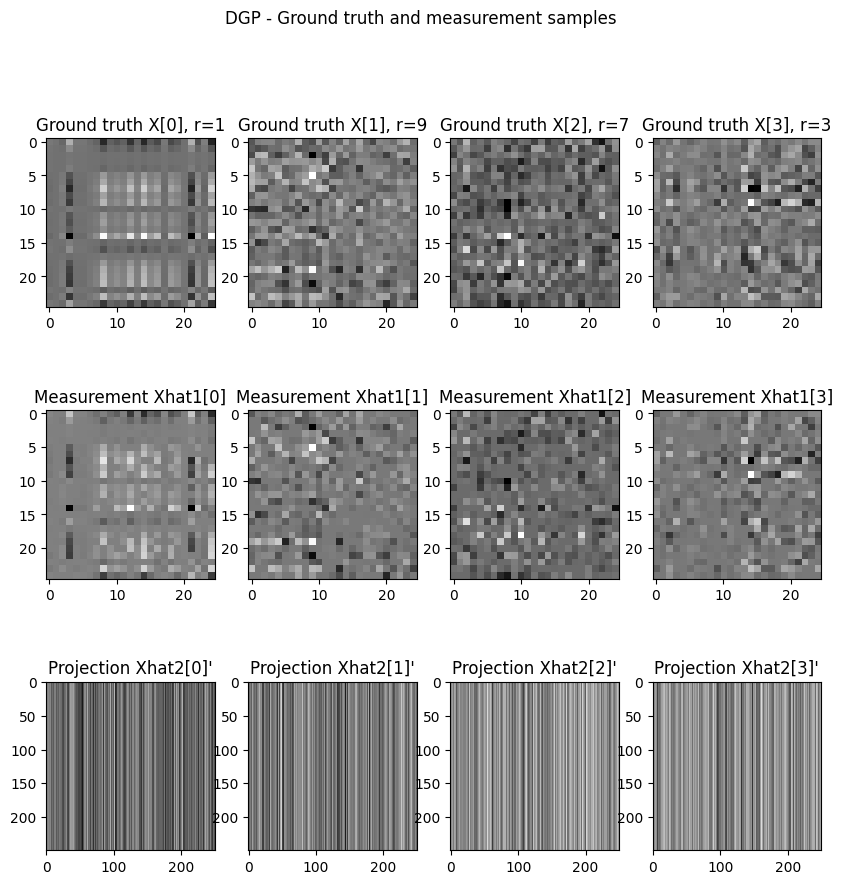

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i in range(4):
    axs[0, i].imshow(X[i], cmap="gray")
    axs[1, i].imshow(Xhat[i], cmap="gray")
    # Take traces vector and stack copies of the same trace to visualize
    axs[2, i].imshow(traces[i] * jnp.ones((traces.shape[-1], traces.shape[-1])), cmap="gray")
    axs[0, i].set_title(f"Ground truth X[{i}], r={jnp.linalg.matrix_rank(X[i])}")
    axs[1, i].set_title(f"Measurement Xhat1[{i}]")
    axs[2, i].set_title(f"Projection Xhat2[{i}]'")
plt.suptitle("DGP - Ground truth and measurement samples")
plt.show()

by way of example, we handle the final adding on of bias ourselves, rather than letting the `linear` layer do it, to demonstrate how to use custom parameters in models.

In [10]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid for binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

In [11]:
def exponential_decay_schedule(initial_lr, decay_rate, decay_steps):
    def schedule(step):
        return initial_lr * decay_rate ** (step / decay_steps)
    return schedule

def plot_loss_curves(train_loss, val_loss):
    fig, ax = plt.subplots()
    ax.plot(train_loss, label="Training Loss")
    ax.plot(val_loss, label="Validation Loss")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Validation Loss")
    ax.legend()
    plt.show()
    
    return fig

def plot_eigenvalues(wR, multilayer: bool = False):
    fig, ax = plt.subplots()
    x = np.linspace(-1, 1, 1000)
    ax.plot(x, np.sqrt(1 - x**2), 'k')
    ax.plot(x, -np.sqrt(1 - x**2), 'k')
    if multilayer:
        for i, weights in enumerate(wR):
            eigvals, _ = np.linalg.eig(weights)
            ax.plot(np.real(eigvals), np.imag(eigvals), '.', label=f"Layer {i}")
        ax.legend()
    else:
        eigvals, _ = np.linalg.eig(wR)
        ax.plot(np.real(eigvals), np.imag(eigvals), '.')
    ax.set_title("Eigenvalues of Recurrent Weights")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    # equal axis
    ax.set_aspect('equal', adjustable='box')
    plt.show()    
    return fig

In [12]:
# xs, Y, rank = get_data_densematrix(5000, 250, 250, mask_prob=1/2,
#                                     key=jrandom.key(13), rank_threshold=0.2,
#                                     measurement_type="trace", include_X=False)
# # #iter_data = dataloader((xs, ys), batch_size=32)
# xs.shape[-1]

In [13]:
# #inputdim = xs.shape[-1]
model = RNN(in_size=198, 
             out_size=1, 
             hidden_size=98, 
             key=jrandom.key(12))
model.cell, model.cell.weight_ih.shape, model.cell.weight_hh.shape

(GRUCell(
   weight_ih=f32[294,198],
   weight_hh=f32[294,98],
   bias=f32[294],
   bias_n=f32[98],
   input_size=198,
   hidden_size=98,
   use_bias=True
 ),
 (294, 198),
 (294, 98))

In [14]:
#lr_schedule = exponential_decay_schedule(3e-3, 0.99, 1000)
#optim = optax.adam(learning_rate=lr_schedule)
#opt_state = optim.init(model)

In [29]:
def main(
    dataset_size=10000,
    val_size=1000,
    batch_size=32,
    initial_lr=3e-3,
    decay_rate=0.999,
    steps=1000,
    hidden_size=64,
    depth=1,
    #weight_decay=1e-5,
    seed=5678,
):
    data_key, model_key = jrandom.split(jrandom.key(seed), 2)
    xs, ys, _ = get_data_densematrix(dataset_size+val_size, 250, 250, 
                                    mask_prob=1/2,
                                    key=data_key, 
                                    rank_threshold=0.2,
                                    measurement_type="mask", 
                                    include_X=False)
    xs_train, ys_train = xs[0:dataset_size], ys[0:dataset_size]
    print("Generated training data. Dimensions:", xs_train.shape, ys_train.shape)
    iter_data = dataloader((xs_train, ys_train), batch_size) 
    inputdim = xs_train.shape[-1]
    print("Created training data loader.")
    
    # Create validation set
    xs_val, ys_val = xs[dataset_size:], ys[dataset_size:]
    xs, ys, _ = None, None, None
    print("Generated validation set. Dimensions:", xs_val.shape, ys_val.shape)
    
    # Create learning rate schedule
    lr_schedule = exponential_decay_schedule(initial_lr, decay_rate, steps)
    print("Learning rate schedule created.")
    
    # Create the model
    model = RNN(in_size=inputdim, out_size=1, 
                hidden_size=hidden_size, key=model_key)
    print("RNN model initialized. Input dimensions: ", inputdim, "; hidden size: ", hidden_size, "; output size: 1.")
    wRinit = model.cell.weight_hh
    print("Initial recurrent weights saved.")

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        params = eqx.filter(model, eqx.is_array)
        updates, opt_state = optim.update(grads, opt_state, params)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print("JIT compilation of loss and step complete.")
    
    optim = optax.adam(learning_rate=lr_schedule)
    opt_state = optim.init(model)
    print("Adam optimizer initialized.")
    print("Training starting.")
    
    losses = []
    val_losses = []
    for step, (x, y) in zip(range(steps), iter_data):
        if step == 0:
            print("x:", x.shape, "y:", y.shape, "optimizer:", type(opt_state))
            print("Model cell:", model.cell)
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        # Validation loss
        pred_ys_val = jax.vmap(model)(xs_val)
        val_loss = -jnp.mean(ys_val * jnp.log(pred_ys_val) + (1 - ys_val) * jnp.log(1 - pred_ys_val)).item()
        # Append the training and validation loss
        losses.append(loss)
        val_losses.append(val_loss)
        # Print the loss every 10 steps, and at the final step
        if step % 50 == 0 or step == steps - 1:
            print(f"step={step}, loss={loss}")
        # Middle of training, save the recurrent weights
        if step == steps // 2:
            wRmid = model.cell.weight_hh
    
    wRend = model.cell.weight_hh
    
    pred_ys = jax.vmap(model)(xs_train)
    
    num_correct = jnp.sum((pred_ys > 0.5) == ys_train)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")
    
    # Plot training and validation loss curves
    lossfig = plot_loss_curves(losses, val_losses)
    
    # Save the model
    return model, lossfig, wRinit, wRmid, wRend

`eqx.filter_value_and_grad` will calculate the gradient with respect to all floating-point arrays in the first argument (`model`). In this case the `model` parameters will be differentiated, whilst `model.hidden_size` is an integer and will get `None` as its gradient.

Likewise, `eqx.filter_jit` will look at all the arguments passed to `make_step`, and automatically JIT-trace every array and JIT-static everything else. In this case the `model` parameters and the data `x` and `y` will be traced, whilst `model.hidden_size` is an integer and will be static'd instead.

Generated training data. Dimensions: (10000, 250, 250) (10000, 1)
Created training data loader.
Generated validation set. Dimensions: (1000, 250, 250) (1000, 1)
Learning rate schedule created.
RNN model initialized. Input dimensions:  250 ; hidden size:  64 ; output size: 1.
Initial recurrent weights saved.
JIT compilation of loss and step complete.
Adam optimizer initialized.
Training starting.
x: (32, 250, 250) y: (32, 1) optimizer: <class 'tuple'>
Model cell: GRUCell(
  weight_ih=f32[192,250],
  weight_hh=f32[192,64],
  bias=f32[192],
  bias_n=f32[64],
  input_size=250,
  hidden_size=64,
  use_bias=True
)
step=0, loss=0.6894161701202393
step=50, loss=0.7101572751998901
step=100, loss=0.6108949184417725
step=150, loss=0.5265828371047974
step=200, loss=0.3591899275779724
step=250, loss=0.31087249517440796
step=300, loss=0.5937666296958923
step=350, loss=0.1748272329568863
step=400, loss=0.2816855311393738
step=450, loss=0.3275117874145508
step=500, loss=0.17562341690063477
step=550, l

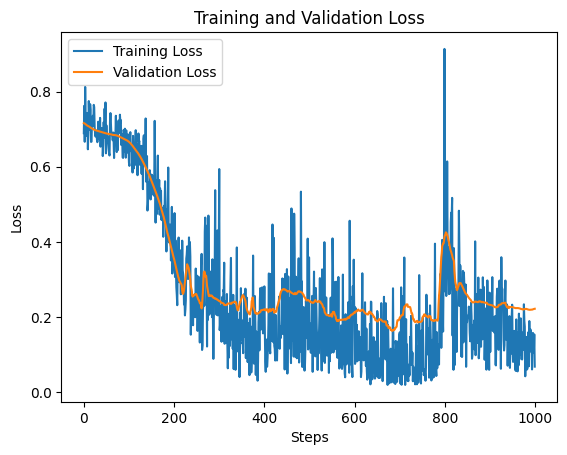

In [30]:
trainedmodel, lossfig, wRinit, wRmid, wRend = main(dynamic=False)

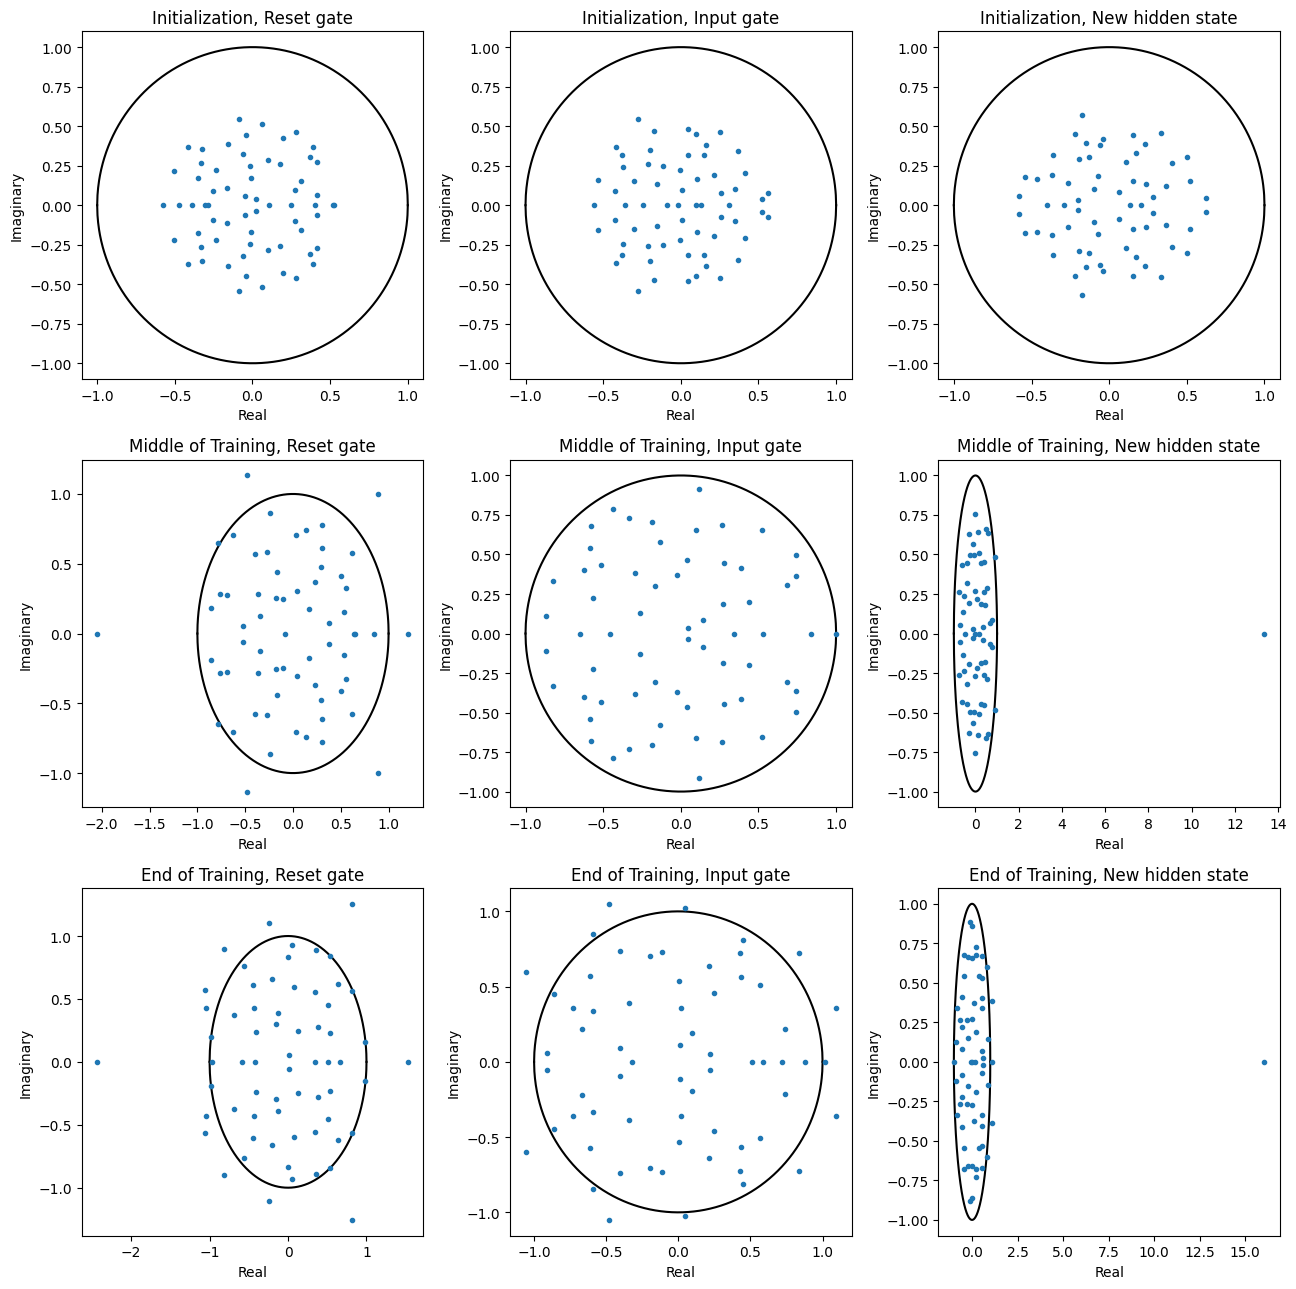

In [31]:
# Split each set of recurrent weights (288, 96) between 
# update gate, reset gate, and candidate hidden state weights.

# Source code of the hidden state update function:
# igates = jnp.split(self.weight_ih @ input + bias, 3)
# hgates = jnp.split(self.weight_hh @ hidden, 3)
# reset = jnn.sigmoid(igates[0] + hgates[0])
# inp = jnn.sigmoid(igates[1] + hgates[1])
# new = jnn.tanh(igates[2] + reset * (hgates[2] + bias_n))
# return new + inp * (hidden - new)
    
# Split the weights into the three components
def split_weights(wR):
    return jnp.split(wR, 3, axis=0)

wRinitsplit = split_weights(wRinit)
wRmidsplit = split_weights(wRmid)
wRendsplit = split_weights(wRend)

resetW = [wRinitsplit[0], wRmidsplit[0], wRendsplit[0]]
inputW = [wRinitsplit[1], wRmidsplit[1], wRendsplit[1]]
newW = [wRinitsplit[2], wRmidsplit[2], wRendsplit[2]]

# Create 3 x 3 panel of plots showing the eigenvalues of the reset, input, and new weights, 
# at initialization, middle of training, and end of training.
fig, axs = plt.subplots(3, 3, figsize=(13, 13))
rowlabels = ["Initialization", "Middle of Training", "End of Training"]
x = np.linspace(-1, 1, 1000)
for i, (reset, inp, new) in enumerate(zip(resetW, inputW, newW)):
    for j, weights in enumerate([reset, inp, new]):
        axs[i, j].plot(x, np.sqrt(1 - x**2), 'k')
        axs[i, j].plot(x, -np.sqrt(1 - x**2), 'k')
        eigvals, _ = np.linalg.eig(weights)
        axs[i, j].plot(np.real(eigvals), np.imag(eigvals), '.')
        axs[i, j].set_title(f"{rowlabels[i]}, {['Reset gate', 'Input gate', 'New hidden state'][j]}")
        axs[i, j].set_xlabel("Real")
        axs[i, j].set_ylabel("Imaginary")
        #axs[i, j].set_aspect('equal', adjustable='box')
#plt.suptitle("Eigenvalues of Recurrent Weights")
fig.tight_layout()
plt.show()

In [32]:
# Test the trained model on a new test set and evaluate the accuracy
data_key, _ = jrandom.split(jrandom.key(4134))
test_xs, test_ys, _ = get_data_densematrix(500, 250, 250, key=data_key,
                                           mask_prob=1/2, rank_threshold=0.2,
                                           measurement_type="mask", include_X=False)
#test_xs, test_ys = get_data_spirals(1000, key=data_key)
#test_xs = test_xs + jrandom.normal(data_key, test_xs.shape) * 0.5
pred_test_ys = jax.vmap(trainedmodel)(test_xs)
num_correct = jnp.sum((pred_test_ys > 0.5) == test_ys)
test_accuracy = (num_correct / 500).item()
print(f"Test accuracy = {test_accuracy}")

Test accuracy = 0.9200000166893005


In [35]:
# Instead of a single forward pass, use 10 forward passes on the same input to compute the prediction
def dynamic_forward(model, x, y, nb_fwdpasses):
    for i in range(nb_fwdpasses - 1):
        pred_y = jax.vmap(model)(x)
        accuracy = jnp.mean((pred_y > 0.5) == y)
        print(f"Accuracy at step {i} = {accuracy}")
    return pred_y

dynamic_forward(trainedmodel, test_xs, test_ys, 10)


Accuracy at step 0 = 0.9200000166893005
Accuracy at step 1 = 0.9200000166893005
Accuracy at step 2 = 0.9200000166893005
Accuracy at step 3 = 0.9200000166893005
Accuracy at step 4 = 0.9200000166893005
Accuracy at step 5 = 0.9200000166893005
Accuracy at step 6 = 0.9200000166893005
Accuracy at step 7 = 0.9200000166893005
Accuracy at step 8 = 0.9200000166893005


Array([[0.0659438 ],
       [0.18456738],
       [0.964522  ],
       [0.99730337],
       [0.07616091],
       [0.02405782],
       [0.21245138],
       [0.0482465 ],
       [0.99075186],
       [0.95699626],
       [0.6096774 ],
       [0.99507254],
       [0.9520681 ],
       [0.9427739 ],
       [0.9514997 ],
       [0.21965356],
       [0.0211184 ],
       [0.97357833],
       [0.9883287 ],
       [0.997244  ],
       [0.00257386],
       [0.7059556 ],
       [0.09797763],
       [0.00325021],
       [0.9985954 ],
       [0.99675214],
       [0.996366  ],
       [0.37317908],
       [0.9929756 ],
       [0.19643824],
       [0.99300706],
       [0.02443337],
       [0.97510684],
       [0.04471545],
       [0.86597365],
       [0.99145836],
       [0.00671455],
       [0.9934301 ],
       [0.9895201 ],
       [0.02006177],
       [0.20012034],
       [0.54434174],
       [0.01589951],
       [0.99638855],
       [0.98556024],
       [0.08498917],
       [0.16189219],
       [0.755

In [53]:
jnp.mean(test_ys), jnp.mean(pred_test_ys)

(Array(0.51000005, dtype=float32), Array(0.5519063, dtype=float32))

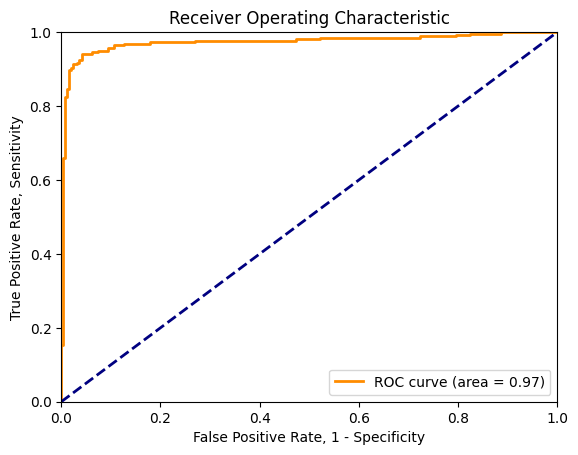

In [54]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(test_ys, pred_test_ys)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate, 1 - Specificity")
plt.ylabel("True Positive Rate, Sensitivity")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()